## How a data scientist works 

Data scientists tend to be in the following situation.

They tend to have a business task, and they work to satisfy the implied ask.

Let's take as our example task predicting the future height of make adult children from an average of the parent's heights called the mid-height.


To work, we import packages from our chosen environment. We will work in Python. Python data science environments tend to be fairly fragile with respect to version. And there may be requirements to use packages that are sufficiently up to date.

In [1]:
# import packages we are going to use
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

Now we load the data. Many data scientists are accustomed to being able to load all of their data into memory and train models as they wish. More commonly data is in a relational database or large data store such as Spark/Hadoop. We will just use data stored in a file as an example.

In [2]:
# read comma separated data file (csv)
d = pd.read_csv("../data/Galton_height/Galton.csv")

In [3]:
# print a few rows of the data
d

,Child,Midparent
0,61.7,70.5
1,61.7,68.5
2,61.7,65.5
3,61.7,64.5
4,61.7,64.0
...,...,...
923,73.7,69.5
924,73.7,69.5
925,73.7,69.5
926,73.7,69.5


In [4]:
# step 0 reserve some of the data we *could*
# have used for training for testing/evaluaiton
np.random.seed(2022)
is_train = np.random.uniform(size=d.shape[0]) <= 0.8
d_train = d.loc[is_train == True, :].reset_index(
    drop=True, inplace=False)
d_test = d.loc[is_train == False, :].reset_index(
    drop=True, inplace=False)

In [5]:
d_train.shape

(731, 2)

In [6]:
d_test.shape

(197, 2)

Building a machine learning or statistical model usually follows the following pattern:

  * Build a modeling object. This object instantiates choice of modeling technique and selection of hyper-parameters.  Hyper-parameters are just the over-done name for any controls or choices that effect how model fitting is done. They are called "hyper-parameters" to stay out of the way of statisticians who use the term "parameters" to refer to inferred attributes of the fit model. In statistics "inference" is often associated with model fitting, not model application.
  * Fitting the model to data. This is where we ask the model to memorize facts about the training data. If what is memorized turns out ot be useful in the future we call this "learning", if it is not we call it memorization of "over fitting."
  * Apply the model to data and diagnose the quality of the model fit. For modern machine learning models (decision trees, ensembles, and neural nets) the performance of the model on training data is not trusted and we expect to evaluate the model on additional "test" or "held-out" data.

In [7]:
# step 1/3: instantiate model
model = LinearRegression()
model_vars = ['Midparent']

In [8]:
# at this point the model attributes
# are largely configuration
vars(model)

{'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'n_jobs': None,
 'positive': False}

In [9]:
# step 2/3 fit or train model
result = model.fit(
    # 2-d array of explanatory variables
    # these are the types of measurements we assume 
    # will be available at model application time
    d_train.loc[:, model_vars], 
    # 1-d vector of dependent values
    # these are the quantities we wish to know
    d_train['Child']  
)


In [10]:
# Now the model has many more inferred 
# attributes.
# Inferred in the statistical is the hope
# that estimates made on the sample before us
# represent the overall population.
vars(model)

{'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([0.63835181]),
 '_residues': 3543.1755700525364,
 'rank_': 1,
 'singular_': array([48.75686489]),
 'intercept_': 24.526949000046912}

For a linear model or for a generalized linear model the only interesting parts of the fit model are the coefficients and intercept

In [11]:
{k: v for k, v in zip(model_vars, model.coef_)}

{'Midparent': 0.6383518059060636}

In [12]:
model.intercept_

24.526949000046912

In [13]:
# step 3/3 get the model predictions
preds_by_model = model.predict(d_test.loc[:, model_vars])

preds_by_model[0:5]

array([67.6156959 , 66.97734409, 66.97734409, 65.70064048, 69.53075132])

Aside, what is the liner model actually doing?

It is just applying a bonus per column. We can implement prediction by hand as follows.

In [14]:
preds_by_hand = (
    24.526949000046912 + 0.6383518059060636 * np.array(d_test['Midparent'])
)

preds_by_hand[0:5]

array([67.6156959 , 66.97734409, 66.97734409, 65.70064048, 69.53075132])

In [15]:
max_diff = np.max(np.abs(preds_by_model - preds_by_hand))
assert max_diff < 1e-5

max_diff

0.0

The data scientist then uses some model evaluation techniques to determine if the model is acceptable or not. Some of these evaluation techniques are quantitative, such as the Pearson-R correlation statistic.

In [16]:
correlation = pearsonr(
    x=preds_by_model,
    y=d_test['Child'])
assert correlation[0] > 0.4
assert correlation[1] < 0.01

correlation

(0.4484038896846286, 3.90073460073052e-11)

For the Pearson R correlation the first number is a measure of model quality (a value where 1 is perfect, and 0 is useless), and the second entry is a measure of unreliability due to data set size called the significance or p-value (zero being good).

A common qualitative summary is the scatter plot.

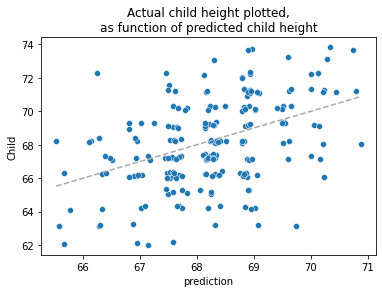

In [17]:
plot_frame = d_test.loc[:, ['Child']].reset_index(
    inplace=False, drop=True)
jitter_size = 0.1  # add noise to points for legibility
plot_frame['Child'] = (
    plot_frame['Child'] 
    + jitter_size * np.random.normal(size=plot_frame.shape[0]))
plot_frame['prediction'] = (
    preds_by_model
    + jitter_size * np.random.normal(size=plot_frame.shape[0]))

sns.scatterplot(data=plot_frame, x='prediction', y='Child')
plt.plot(
    [np.min(plot_frame['prediction']),
     np.max(plot_frame['prediction'])],
    [np.min(plot_frame['prediction']),
     np.max(plot_frame['prediction'])],
    color='darkgrey', 
    linestyle='dashed')
_ = plt.title(
"""Actual child height plotted,
as function of predicted child height""")

At this point the data scientist *hopes* their job is over and passes the model off to somebody else.

In [18]:
# save model
with open('model.pkl', 'wb') as of:
    pickle.dump(
        obj=model,
        file=of
    )

### Appendix

Exact definition of inference.

From *The Cambridge Dictionary of Statistics*, 2nd Edition, B. S. Everitt:

> **Inference:** The process of drawing conclusions about a population on the basis of measurements or observations made on asample of individuals from the population.

The sense this is used in, this is the hope that fitting the model on the training data nearly finds the model we would have fit on the population the training data was either drawn from or is hoped to represent.